In [8]:
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
from f1tenth_gym.envs.track import Track

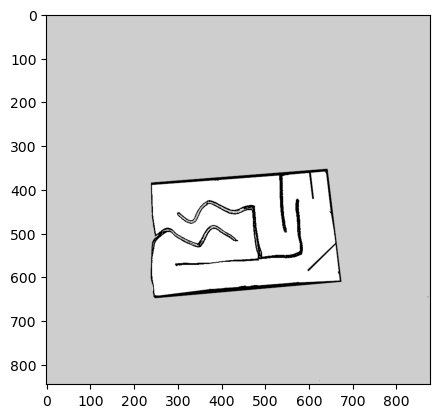

In [ ]:
map = '/Users/bryanalfaro/Documents/Problem_Sets/f1_final/f1tenth_gym/maps/race3/race3.png'
map_np = plt.imread(map)
plt.imshow(map_np, cmap='gray')
track = Track.from_track_name("race3")


In [117]:
def _spawn_obstacle(
        track : Track,
        centerline,
        room=10, 
        r_min=0.2,
        margin=0.4
    ):
        """
        spawns a random box on track room away from ego
        only draws circles for now, with low lidar resolution should be fine

        Args:
            room (int): minimum distance in indices from ego to spawn location 
            r_min (float): minimum obstacle size
            margin (float): how much track width to leave on either side of the circle
        """
        # ego_x, ego_y = self.start_xs[self.ego_idx], self.start_ys[self.ego_idx] #, self.poses_yaw[self.ego_idx]
        # pt = np.array([ego_x, ego_y])
        # _, _, _, n_idx = nearest_point_on_trajectory(pt.astype(np.float64), self.centerline[:, :2].astype(np.float64))

        # deletes indices in B_r(pt) from selection pool
        # TODO: idk if these checks are necessary,
        # agent reset might account for updated occupancy map
        # track.centerline.
        idxs = np.arange(len(track.centerline.xs))
        # close = idxs.take(np.arange(n_idx - room, n_idx + room + 1), mode='wrap')
        # idxs = np.delete(idxs, close)

        # randomly select (s, ey) from remaining indices
        rand_idx = np.random.choice(idxs)
        print(rand_idx)
        xc, yc = centerline[rand_idx, :2]
        xcp1, ycp1 = centerline[(rand_idx + 1) % centerline.shape[0], :2]
        
        yaw = np.arctan2(ycp1 - yc, xcp1 - xc)
        wl, wr = centerline[rand_idx, 2:4] # track width at (xc, yc)
        s, _, _ = track.cartesian_to_frenet(xc, yc, yaw)
        print(s)
        ey = np.random.uniform(-wr, wl)
        # print(-wr <= ey <= wl)
        # print(f'{xc}, {yc}')
        
        x, y, _ = track.frenet_to_cartesian(s, ey, 0.0)
        print(np.linalg.norm([x - xc, y-yc], 2))
        # print(f'{x}, {y}')
        # select appropriate radius using track width and ey
        # if ey < 0: # leave RHS clear
        #     r_max = wr - np.abs(ey) - margin
        # else: # leave LHS clear
        #     r_max = wl - np.abs(ey) - margin
        # leave a gap of at least size margin:
        r_max = (wl + wr - margin) / 2
        r_max = max(r_min, r_max) # to ensure nonnegative
        r = np.random.uniform(r_min, r_max)
        return _draw_circle(track, x, y, r), xc, yc, x, y

def _draw_circle(track : Track, x, y, r):
    """draws circle on the occupancy grid"""
    scale = track.spec.resolution # conversion faactor pixel -> m
    ox, oy, yaw = track.spec.origin
    if r < 0.0:
        r = 0.0
    r = int(r / scale)
    dx = x - ox
    dy = y - oy
    c = np.cos(-yaw)
    s = np.sin(-yaw)
    x = c * dx - s * dy
    y = s * dx + c * dy
    x = int(x / scale) 
    y = int(y / scale)
    return cv2.circle(track.occupancy_map, (x, y), r, 0.0, -1)


In [118]:
def to_img(x, y, origin):
    dx = x - origin[0]
    dy = y - origin[1]
    c = np.cos(-origin[2])
    s = np.sin(-origin[2])
    x = c * dx - s * dy
    y = s * dx + c * dy
    scale = 0.05
    x = (x / scale) 
    y = (y / scale)
    return x, y

624
81.57120712905305
15.677539698263093


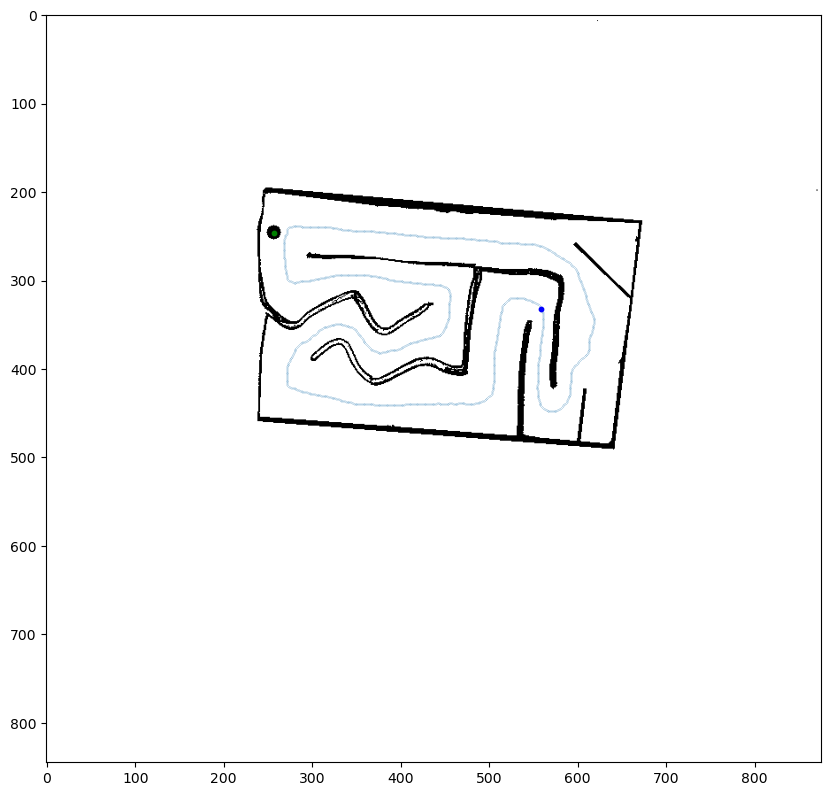

In [123]:
# import time
map = '/Users/bryanalfaro/Documents/Problem_Sets/f1_final/f1tenth_gym/maps/race3/race3.png'
map_np = plt.imread(map)
# plt.figure()
# plt.imshow(map_np, cmap='gray')
track = Track.from_track_name("race3")
origin = [-20, -12.6, 0]
# n = 1
centerline = np.loadtxt('/Users/bryanalfaro/Documents/Problem_Sets/f1_final/f1tenth_gym/maps/race3/race3_centerline.csv', delimiter=',').astype(np.float32)
dx = centerline[:, 0] - origin[0]
dy = centerline[:, 1] - origin[1]
c = np.cos(-origin[2])
s = np.sin(-origin[2])
x = c * dx - s * dy
y = s * dx + c * dy
scale = 0.05
x = (x / scale) 
y = (y / scale)
for _ in range(1):
    track.occupancy_map, xc, yc, xs, ys = _spawn_obstacle(track, centerline)
    xc, yc = to_img(xc, yc, origin)
    xs, ys = to_img(xs, ys, origin)
    plt.figure(figsize=(10, 10))
    plt.imshow(track.occupancy_map, cmap='gray')
    plt.scatter(x, y, s=0.01)
    plt.scatter(xc, yc, color='b', s=10) # should give randomly sampled point on centerline
    plt.scatter(xs, ys, color='g', s=10) # should give perturbation of above point

    # time.sleep(1)
# plt.figure()xs